# Calculating Hausdorff distance among AR tracks

In [21]:
import pandas as pd
from hausdorff import hausdorff_distance
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

**Load the Coordinates DataFrame**

In [3]:
#
## Final Method
## Each track is represented by the union of its axis coordinates
#

# Generating a distance matrix with this is slower. >20 coordinate pairs per timestep -> ~120 minute execution time
tracks = pd.read_csv("WestCoastAR-Coords.csv")

**Get track coordinate lists**

In [4]:
# Parse the longitude coordinates
x = [ast.literal_eval(tracks.iloc[i]['x_coords']) for i in range(len(tracks))]
# And the latitude coordinates
y = [ast.literal_eval(tracks.iloc[i]['y_coords']) for i in range(len(tracks))]
# Combine each into a coordinates list
coords = [list(zip(x[i],y[i])) for i in range(len(tracks))]

**Calculate the Hausdorff distance between each AR track and build a distance matrix b/w every AR track.**

In [5]:
def Hausdorff_Distance_Array(coords):

# Generates a 2-d distance matrix containing Hausdorff distances between AR track coordinates.


    # Initialize the distance array
    d = np.zeros((len(coords),len(coords)))

    # Loop through each coordinate pair and calculate the HD, add to distance array
    for i in range(len(coords)):

        for j in range(i+1,len(coords)):

            d[i,j] = hausdorff_distance(np.asarray(coords[i]),np.asarray(coords[j]))
            
            
    # Reflect the UT to LT, fills in the rest
    d2 = d + d.T


    return d2

**Implementing the function above** 

In [6]:
#distance_matrix_AxisCoords = Hausdorff_Distance_Array(coords) # 122 minutes, not bad actually

**Save the distance array to save time in the future**

In [20]:
# np.save('WestCoastAR-Coords_Distances',distance_matrix_AxisCoords) # Do this as needed

# Generating Clusters using the Haussdorf distance matrix

**Load the distance matrix**

In [9]:
distance_matrix = np.load('WestCoastAR-Coords_Distances.npy')

**Implementing K-Medoids with distance matrix**

In [10]:
def generate_Nclusters(distance_matrix,n_clusters):

    labels = []
    inertias = []
    names = []

    for i in np.arange(1,n_clusters):

        # Implement sklearn_extra's kmedoids algorithm
        clustering  = KMedoids(n_clusters = i, random_state=42).fit(distance_matrix)
        # Add the cluster labels and inertia to the output lists
        labels.append(clustering.labels_)
        inertias.append(clustering.inertia_)
        names.append(i)
        
    return labels, inertias, names

In [11]:
labels, inertias, names = generate_Nclusters(distance_matrix,10)

**Make a dataframe of the potential clustering combinations**

In [12]:
# Make a dataframe of clusterIDs for each track using the labels from KMedoids
track_clusters = pd.DataFrame(data = labels).T # transpose it from row to columns

# Make some columns names
colnames = ['{}_Clusters'.format(label) for label in names]

# Set the column names
track_clusters.columns = colnames

# Set the index to the trackID
trackids = tracks['trackid'] # Grab the trackids from the dataframe
track_clusters['trackid'] = tracks['trackid']
#track_clusters.set_index(trackids)

**Visualize the clustering performance via an inertia elbow diagram**

Text(0.5, 1.0, 'Hausdorff Distance KMedoids Inertia Plot')

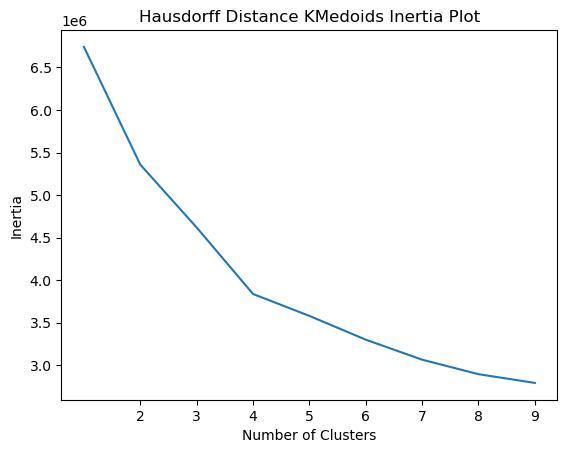

In [13]:
plt.plot(inertias)
plt.xticks(np.arange(1,9),np.arange(2,10))
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.title('Hausdorff Distance KMedoids Inertia Plot') 

**It seems like 4 clusters is optimal**

In [14]:
final_clusterlabels = track_clusters[['4_Clusters','trackid']]

# Visualize Clustering Results and Label AR Clusters

In [15]:
# Load in the AR Tracks DataFrame
ar_tracks = pd.read_csv('WestCoastAR-TCP.csv')

In [16]:
# Add the labels to each trackid in the AR climatology dataframe
labeled_tracks = ar_tracks.merge(final_clusterlabels,left_on='Trackid',right_on='trackid')

**Scatterplot of centroid coordinates labeled by cluster**

Text(0.5, 1.0, 'AR Track Clustering- Directed Hausdorff')

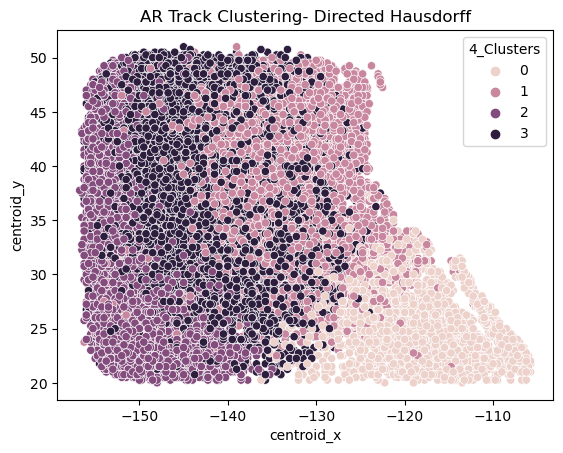

In [18]:
sns.scatterplot(labeled_tracks,x='centroid_x',y='centroid_y',hue='4_Clusters')
plt.title('AR Track Clustering- Directed Hausdorff')

**Save the Labelled AR Climatology**

In [22]:
labeled_tracks.to_csv('WestCoastAR-TCP_clustered.csv')